In [248]:
%matplotlib inline
from pylab import *


from esn.esn_discrete_2d import ESN_discrete as ESN

# root-mean-square error
def rmse(y, y_pred): 
    return sqrt( mean((y-y_pred)**2) );


We use **ESN_discrete** class as it were a DMP.

<img src="esn/esn_discrete_2D.png" width=500>

* **ESN_discrete.imitate_path(path)** runs the regression.

* **ESN_discrete.rollout()** produces a trajectory with the learned weights.


Class of trajectories:

the model trajectory is 
$$
\begin{array}
    x =& a_x e^{-\frac{\left(t-c_x\right)^2}{b_x} }+ t \\
    y =& a_y e^{-\frac{\left(t-c_y\right)^2}{b_y} }+ t 
\end{array}
$$

a single trajectory result from translating and rotating the model trajectory
(given the parameters $a_1, a_2, b_1, b_2, c_1, c_2$) so that its 
start and end points match the **start** and **goal** parameters


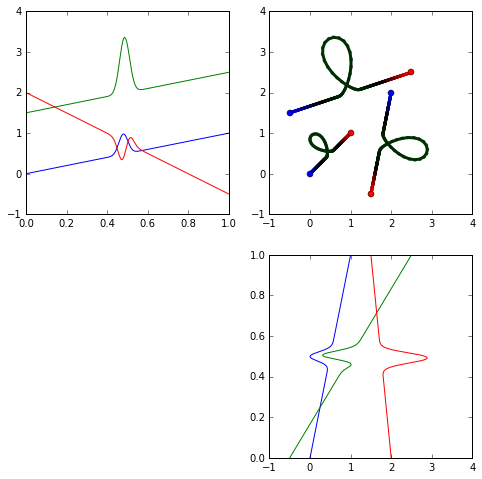

In [249]:

def get_angle(v1,v2) :
    """
    Calculate the angle between two vectors
    v1  (array):   first vector
    v2  (array):   second vector
    """

    if (norm(v1)*norm(v2)) != 0 :     
        cosangle = dot(v2,v1)/(norm(v1)*norm(v2))
        cosangle = maximum(-1,minimum(1, cosangle))
        angle = arccos(cosangle)   
        if cross(v2,v1) < 0 :
            angle = 2*pi - angle  
        return angle
    return None

TIMESTEPS = 200

def gen_trajectory(start, goal, 
                  ax=-0.5, bx=0.001, cx=.5, 
                  ay=0.5,  by=0.001, cy=.48) :
    '''
    Generate an 'e' trajectory
    
    start    (array): start point
    goal     (array): end point
    ax         float: amplitude of the x gaussian
    bx         float: variance of the x gaussian
    cx         float: mean of the x gaussian
    ay         float: amplitude of the y gaussian
    by         float: variance of the y gaussian
    cy         float: mean of the y gaussian
    '''
    
    # assure that these are np.arrays
    start = array(start)
    goal = array(goal)
    
    # the end point of the model trajectory
    unit = [1,1]
    # the end point of the real trajectory 
    # translated to the origin
    target = goal - start
    
    # he angle between model and real
    angle = get_angle(unit, target) 
    
    # create model trajectory
    t = linspace(0,1,TIMESTEPS)
    xunit = ax*exp(-(1./bx)*(t-cx)**2)+t
    yunit = ay*exp(-(1./by)*(t-cy)**2)+t
    
    # rotate
    X = xunit*cos(angle) + yunit*sin(angle)
    Y = -xunit*sin(angle) + yunit*cos(angle)
    
    # scale and traslate
    scale = norm(target)/norm(unit)
    X = X*scale + start[0]
    Y = Y*scale + start[1]
    
    return X,Y,t
     
cc=matplotlib.colors.LinearSegmentedColormap.from_list(
    'my_cm',[[0,0,1],[0,0,0],[0,.2,0],[0,0,0],[1,0,0]])
figure(figsize=(8,8))
    
def plot_t(x,y,t, xlim_=None, ylim_=None, lwidth = None) :
    
    start = (x[0],y[0])
    goal = (x[-1],y[-1])
    
    if xlim_ == None: xlim_=[-1, 4]
    if ylim_ == None: ylim_=[-1, 4]
    if lwidth == None: lwidth=3
        
    subplot(224)
    plot(x,t)
    xlim(xlim_)
    
    subplot(221)
    plot(t,y)
    ylim(ylim_)
    
    subplot(222)
    for i in xrange(1,len(t)):
        q = (i/float(len(t)))*255.0
        plot(x[(i-1):(i+1)],y[(i-1):(i+1)],lw=lwidth, color=cc(int(q)))
    plot(*start,marker='o', ms=lwidth*2, color='blue')
    plot(*goal,marker='o', ms=lwidth*2, color='red')
    xlim(xlim_)
    ylim(ylim_)
    
def plot_e(start, goal) :
    x,y,t = gen_trajectory(start, goal)
    plot_t(x,y,t)

plot_e([0,0],[1,1])
plot_e([-.5,1.5],[2.5,2.5])
plot_e([2,2],[1.5,-.5])


### Trajectories

In [250]:
r = 1.0
xr = 0.0001
NY = 9
angle_range = .8
x = linspace(xr,-xr, NY)
a = np.pi*((1.0-angle_range)*.5) +(np.pi*angle_range)*(1 -(x+xr)/(xr*2))
rr = a/np.pi*r
start_Y =[]
goal_Y =[]
for t in range(NY):
    start_Y.append( [x[t], 0] )
    goal_Y.append( [x[t] + rr[t]*cos(a[t]), rr[t]*sin(a[t])] )

Y = []
for k in range(NY):
    x,y,t = gen_trajectory(start_Y[k], goal_Y[k])
    Y.append(vstack((x,y)).T )

NT = NY-1

dx = xr/float(NT)
x = linspace(xr-dx,-xr+dx, NT)
a = np.pi*((1.0-angle_range)*.5) +(np.pi*angle_range)*(1 -(x+xr)/(xr*2))
rr = a/np.pi*r
start_T =[]
goal_T =[]
for t in range(NT):
    start_T.append( [x[t], 0] )
    goal_T.append( [x[t] + rr[t]*cos(a[t]), rr[t]*sin(a[t])] )

T = []
for k in range(NT):
    x,y,t = gen_trajectory(start_T[k], goal_T[k])
    T.append(vstack((x,y)).T )

print "done"

done


done


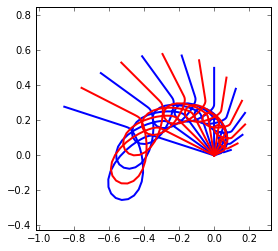

In [251]:
fig = figure()
ax = fig.add_subplot(111, aspect="equal")
ax.set_xlim(-xr-rr[-1]*1.2,xr+rr[1]*1.3)
ax.set_ylim(-rr[-1]*.5,rr[-1])
    
for k in range(NY):
    plot(*Y[k].T, color="blue", lw=2)
for k in range(NT):
    plot(*T[k].T, color="red", lw=2)

print "done"

### Initialize the echo-state network

In [252]:
sim = ESN(
    N       = 3000,
    timesteps = TIMESTEPS,
    dt      = 0.001,
    tau     = 0.05,
    alpha   = 0.01,
    beta    = 0.99,
    epsilon = 1.0e-60,
    lmbd    = 0.5e-3
)
print "done"

done


### Learning

Regression

In [253]:
# run the regression
sim.imitate_path(Y)
print "done"

done


### Test
Reproducing the trajectories

In [254]:
# reproduce the training trajectories
Y_r = []
for k in xrange(NY) :  
    y_r = sim.rollout(y0=start_Y[k], goal=goal_Y[k])
    Y_r.append(y_r.T)
    
# reproduce the test trajectories
T_r = []
for k in xrange(NT) :  
    t_r = sim.rollout(y0=start_T[k], goal=goal_T[k])
    T_r.append(t_r.T)
print "done"

done


Computing the errors

In [255]:
Y_rmse = rmse ( array(Y).ravel(), array(Y_r).ravel())
T_rmse = rmse ( array(T).ravel(), array(T_r).ravel())
print "     TRAINING RMSE: {}".format( Y_rmse )
print "         TEST RMSE: {}".format( T_rmse )


     TRAINING RMSE: 0.00333706686484
         TEST RMSE: 0.0042830538881


Plotting the trajectories

done


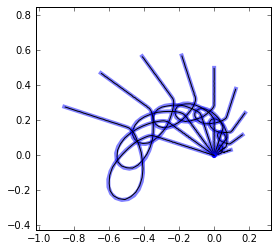

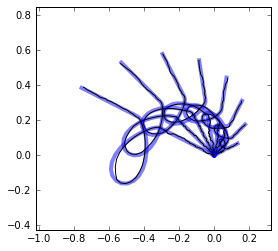

In [256]:
fig = figure()
ax = fig.add_subplot(111, aspect="equal")
ax.set_xlim(-xr-rr[-1]*1.2,xr+rr[1]*1.3)
ax.set_ylim(-rr[-1]*.5,rr[-1])
    
for k in range(NY):
    plot(*Y[k].T, color="blue", lw=4, alpha=.5)
    plot(*Y_r[k].T, color="black", lw=1)

fig = figure()
ax = fig.add_subplot(111, aspect="equal")
ax.set_xlim(-xr-rr[-1]*1.2,xr+rr[1]*1.3)
ax.set_ylim(-rr[-1]*.5,rr[-1])
    
for k in range(NT):
    plot(*T[k].T, color="blue", lw=4, alpha=.5)
    plot(*T_r[k].T, color="black", lw=1)
    
print "done"

Plotting the activity and the spectrogram of the network

(-9.9523350451379624, 9.9523350451379624)

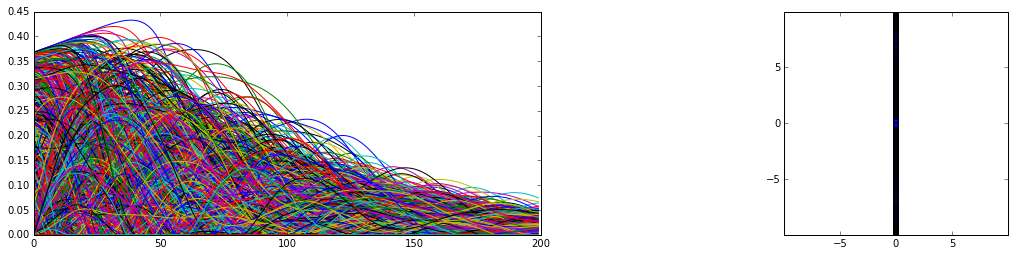

In [257]:
# activity
fig = figure(figsize=(20,4))
ax = fig.add_subplot(121)
x = sim.activations()
pl = ax.plot(x.T)

#spectrogram
ax = fig.add_subplot(122, aspect="equal")
l = eigvals(sim.res.w)
sr = max(abs(l))
sc = ax.scatter(real(l), imag(l))
ax.set_xlim([-sr,sr])
ax.set_ylim([-sr,sr])